<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">BE - ML</div>

# Introduction
Unmanned Aerial Vehicles (UAVs), commonly known as drones, are increasingly being deployed for applications such as surveillance, delivery, environmental monitoring, and disaster management. However, the growing reliance on UAVs also exposes them to significant **cybersecurity risks**, as malicious actors can exploit vulnerabilities in their communication and control systems. To address this challenge, **intrusion detection systems (IDSs)** leveraging machine learning have become an active area of research.

This project utilizes the **Cyber-Physical Dataset for UAVs Under Normal Operations and Cyberattacks**, developed by **Hassler, Mughal, and Ismail (2023)**. The dataset captures both **cyber and physical telemetry data** from UAVs under normal flight conditions and during four distinct types of cyberattacks:

1. **De-authentication Denial-of-Service (DoS) attack**
2. **Replay attack**
3. **False Data Injection (FDI) attack**
4. **Evil Twin attack**

The dataset is composed of two major components:

* **Cyber dataset** containing 37 features that describe network-level parameters and communication behavior.
* **Physical dataset** containing 16 features that represent UAV motion dynamics such as altitude, velocity, position, and orientation.

Each record in the dataset corresponds to either **benign (normal)** operation or one of the aforementioned **attack scenarios**, making it suitable for **binary (normal vs. malicious)** or **multi-class** classification tasks. The data were collected using a custom UAV testbed with real-time attack emulation and monitoring tools.

In this notebook, we focus on building and evaluating machine learning models to **classify UAV activities as either normal or malicious**, thereby contributing to the development of intelligent cyber-physical intrusion detection systems for UAVs.

**Reference:**
Hassler, S. C., Mughal, U. A., & Ismail, M. (2023). *Cyber-Physical Intrusion Detection System for Unmanned Aerial Vehicles*. IEEE Transactions on Intelligent Transportation Systems.
Available via github: [https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks](https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks)


# partie Colin

# partie Mohamed

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import plotly.graph_objects as go
import plotly.express as px
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
import copy

### Data Extraction and Preprocessing Pipeline for the T-ITS Dataset

In [30]:
# === CONFIGURATION ===
csv_path = "Dataset_T-ITS.csv"     # your original file
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)

# === Definition of ranges (1-based, inclusive) ===
ranges = {
    "Benign":       {"Cyber": (1, 9426),     "Physical": (9427, 13717)},
    "DoS Attack":   {"Cyber": (13718, 25389),"Physical": (25390, 26363)},
    "Replay Attack":{"Cyber": (26364, 38370),"Physical": (38371, 39344)},
    "Evil Twin":    {"Cyber": (39345, 45028),"Physical": (45029, 50502)},
    "FDI":          {"Cyber": (50503, 53976),"Physical": (53977, 54784)}
}

# === READ WITHOUT HEADER ===
df_raw = pd.read_csv(csv_path, header=None)
n = len(df_raw)
print(f"📂 File loaded ({n} rows)\n")

# === HEADER DETECTION FUNCTION BY KEYWORD ===
def is_header_line(row):
    return row.astype(str).str.contains("class", case=False, na=False).any()

# === EXTRACTION OF BLOCKS ACCORDING TO RANGES ===
for attack, parts in ranges.items():
    for part_name, (start, end) in parts.items():
        start_idx = max(0, start - 1)
        end_idx = min(n, end)
        sub_df = df_raw.iloc[start_idx:end_idx].copy()

        # Find the header line inside the block
        header_idx = sub_df.index[sub_df.apply(is_header_line, axis=1)]
        if len(header_idx) == 0:
            print(f"⚠️ No header found in {attack} - {part_name} ({start}-{end}), skipped.")
            continue

        header_row = header_idx[0]
        header = sub_df.loc[header_row]

        # Remove lines before the header
        sub_df = sub_df.loc[header_row + 1:]
        sub_df.columns = header
        sub_df.reset_index(drop=True, inplace=True)

        # === 🔹 CLEAN EMPTY COLUMNS ===
        # Remove columns that are entirely empty
        sub_df = sub_df.dropna(axis=1, how='all')

        # Remove columns with empty or undefined names
        sub_df = sub_df.loc[:, [str(c).strip() not in ["", "Unnamed: 0", "Unnamed: 1", "nan"] for c in sub_df.columns]]

        # Remove columns where all values are NaN or just empty commas
        sub_df = sub_df.loc[:, sub_df.apply(lambda col: not all(str(x).strip() in ["", "nan"] for x in col), axis=0)]

        # Count number of valid features
        valid_features = [c for c in sub_df.columns if pd.notna(c) and str(c).strip() != ""]
        n_features = len(valid_features)

        # Save the cleaned block
        filename = f"{attack.replace(' ', '_')}_{part_name}.csv"
        path_out = os.path.join(output_dir, filename)
        sub_df.to_csv(path_out, index=False)

        # Final display
        print(f"✅ {attack} ({part_name}): {len(sub_df)} rows, {n_features} features")

print("\n🎯 Done: all blocks have been extracted and cleaned.")


/tmp/ipykernel_1390/4185885608.py:16: DtypeWarning: Columns (35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(csv_path, header=None)


📂 File loaded (54784 rows)

✅ Benign (Cyber): 9425 rows, 38 features
✅ Benign (Physical): 4290 rows, 17 features
✅ DoS Attack (Cyber): 11671 rows, 38 features
✅ DoS Attack (Physical): 973 rows, 17 features
✅ Replay Attack (Cyber): 12006 rows, 38 features
✅ Replay Attack (Physical): 973 rows, 17 features
✅ Evil Twin (Cyber): 5683 rows, 35 features
✅ Evil Twin (Physical): 5473 rows, 22 features
✅ FDI (Cyber): 3473 rows, 35 features
✅ FDI (Physical): 807 rows, 32 features

🎯 Done: all blocks have been extracted and cleaned.


In [31]:
data_Begnin_Cyber = pd.read_csv('Data/Benign_Cyber.csv')
data_Begnin_Physical = pd.read_csv('Data/Benign_Physical.csv')
data_DoS_Cyber = pd.read_csv('Data/DoS_Attack_Cyber.csv')
data_DoS_Physical = pd.read_csv('Data/DoS_Attack_Physical.csv')
data_Replay_Cyber = pd.read_csv('Data/Replay_Attack_Cyber.csv')
data_Replay_Physical = pd.read_csv('Data/Replay_Attack_Physical.csv')
data_EvilTwin_Cyber = pd.read_csv('Data/Evil_Twin_Cyber.csv')
data_EvilTwin_Physical = pd.read_csv('Data/Evil_Twin_Physical.csv')
data_FDI_Cyber = pd.read_csv('Data/FDI_Cyber.csv')
data_FDI_Physical = pd.read_csv('Data/FDI_Physical.csv')

In [32]:
data_Begnin_Physical.head()

,timestamp_p,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z,class
0,28123.02875,80,0,0,0,0,0,0,68,84,19309,7,65,-15,-5,86,benign
1,28123.55962,80,0,0,0,0,0,0,68,84,19305,7,65,-13,-6,86,benign
2,28124.07690,80,0,0,0,0,0,0,68,83,19303,8,65,-18,-6,85,benign
3,28124.60200,80,0,0,0,-1,0,0,67,83,19307,8,65,-21,-9,84,benign
4,28125.12910,80,0,0,0,-1,0,0,67,85,19309,9,65,-24,-10,84,benign


In [33]:
data_Begnin_Physical.describe()

,timestamp_p,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z
count,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000
mean,38373.622706,71.979021,0.067599,-0.087879,0.103263,-0.546387,-0.241026,55.676923,67.177389,97.350583,20610.464103,39.074592,59.656177,-12.591142,-14.066200,67.952681
std,6880.388077,13.429245,1.315332,0.450349,0.627581,1.660456,0.776307,90.928146,2.791420,342.113961,710.914790,19.965639,23.996521,47.516717,45.159429,62.623750
min,28123.028750,-10.000000,-5.000000,-3.000000,-2.000000,-11.000000,-7.000000,-179.000000,53.000000,10.000000,18909.000000,2.000000,20.000000,-200.000000,-200.000000,-200.000000
25%,31300.990075,70.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,66.000000,79.000000,19817.000000,22.000000,40.000000,-12.000000,-14.000000,80.000000
50%,38485.998845,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000,80.000000,21025.000000,38.000000,61.000000,-4.000000,-5.000000,82.000000
75%,43875.459452,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.000000,69.000000,82.000000,21231.000000,55.000000,79.000000,4.000000,4.000000,84.000000
max,54385.241520,110.000000,5.000000,3.000000,4.000000,8.000000,6.000000,179.000000,74.000000,6553.000000,21356.000000,95.000000,100.000000,68.000000,49.000000,122.000000


### Physical Data exploration

In [5]:
def plot_flight_distance_temperature_continuous(df, title="Courbe continue — timestamp_p vs distance"):
    """
    Trace une ligne continue avec des points colorés par température.
    """
    required_cols = ["timestamp_p", "distance", "temperature"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"❌ Colonne manquante dans le DataFrame : {col}")

    df_sorted = df.sort_values(by="timestamp_p")

    fig = go.Figure()

    # Ligne grise en arrière-plan
    fig.add_trace(go.Scatter(
        x=df_sorted["timestamp_p"],
        y=df_sorted["distance"],
        mode="lines",
        line=dict(color="lightgray", width=1.5),
        name="Trajectoire"
    ))

    # Points colorés par température
    fig.add_trace(go.Scatter(
        x=df_sorted["timestamp_p"],
        y=df_sorted["distance"],
        mode="markers",
        marker=dict(
            color=df_sorted["temperature"],
            colorscale="Plasma",
            size=6,
            colorbar=dict(title="Température"),
            showscale=True
        ),
        name="Température"
    ))

    fig.update_layout(
        title=title,
        xaxis_title="timestamp_p",
        yaxis_title="distance",
        template="plotly_white",
        width=950,
        height=700
    )

    fig.show()



# Exemple d'utilisation :
plot_flight_distance_temperature_continuous(data_Begnin_Physical, 
    title="Courbe continue — Données physiques bénignes")
plot_flight_distance_temperature_continuous(data_DoS_Physical, 
    title="Courbe continue — Données physiques DoS Attack")
plot_flight_distance_temperature_continuous(data_Replay_Physical, 
    title="Courbe continue — Données physiques Replay Attack")


### Cyber Data exploration

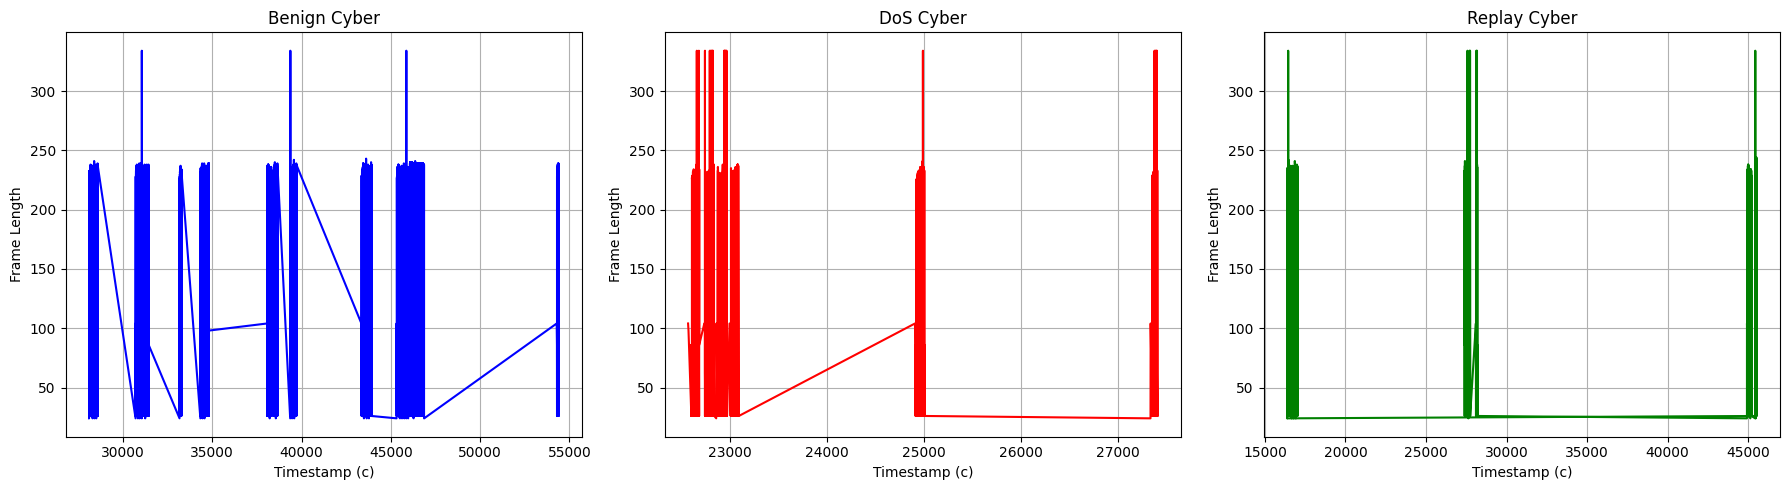

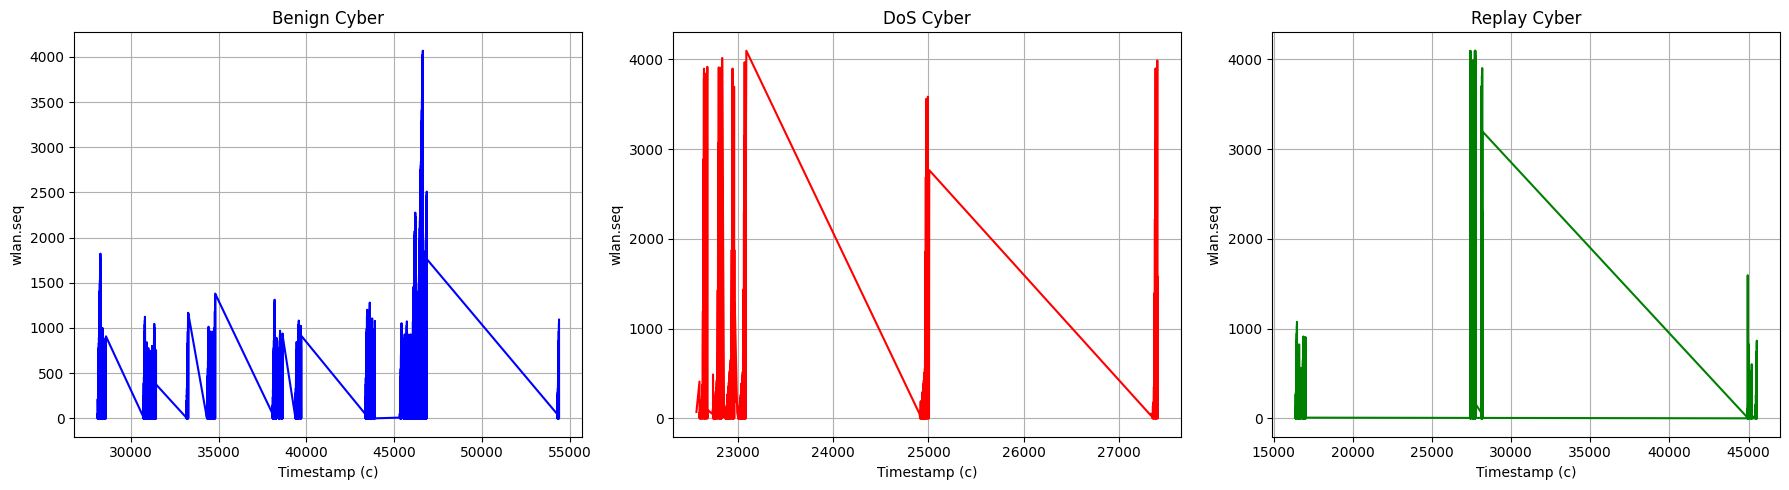

In [ ]:
# 'frame.len' vs 'timestamp_c' for Cyber Data
plt.figure(figsize=(18, 5))

# --- Plot 1 : Benign ---
plt.subplot(1, 3, 1)
plt.plot(data_Begnin_Cyber['timestamp_c'], data_Begnin_Cyber['frame.len'], color='blue')
plt.title('Benign Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('Frame Length')
plt.grid(True)

# --- Plot 2 : DoS ---
plt.subplot(1, 3, 2)
plt.plot(data_DoS_Cyber['timestamp_c'], data_DoS_Cyber['frame.len'], color='red')
plt.title('DoS Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('Frame Length')
plt.grid(True)

# --- Plot 3 : Replay ---
plt.subplot(1, 3, 3)
plt.plot(data_Replay_Cyber['timestamp_c'], data_Replay_Cyber['frame.len'], color='green')
plt.title('Replay Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('Frame Length')
plt.grid(True)

plt.tight_layout()
plt.show()

# 'wlan.seq' vs 'timestamp_c' for Cyber Data
plt.figure(figsize=(18, 5))

# --- Plot 1 : Benign ---
plt.subplot(1, 3, 1)
plt.plot(data_Begnin_Cyber['timestamp_c'], data_Begnin_Cyber['wlan.seq'], color='blue')
plt.title('Benign Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('wlan.seq')
plt.grid(True)

# --- Plot 2 : DoS ---
plt.subplot(1, 3, 2)
plt.plot(data_DoS_Cyber['timestamp_c'], data_DoS_Cyber['wlan.seq'], color='red')
plt.title('DoS Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('wlan.seq')
plt.grid(True)

# --- Plot 3 : Replay ---
plt.subplot(1, 3, 3)
plt.plot(data_Replay_Cyber['timestamp_c'], data_Replay_Cyber['wlan.seq'], color='green')
plt.title('Replay Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('wlan.seq')
plt.grid(True)

plt.tight_layout()
plt.show()


### Merging Physical Data 

In [34]:
# === CONFIGURATION ===
# Path to the folder containing the physical files
input_dir = "Data"       # folder where the CSVs are saved
output_file = "Data/Merged_Physical.csv"

# Exact list of files to merge
files_to_merge = [
    os.path.join(input_dir, "Benign_Physical.csv"),
    os.path.join(input_dir, "DoS_Attack_Physical.csv"),
    os.path.join(input_dir, "Replay_Attack_Physical.csv")
]

# === Check file existence ===
for f in files_to_merge:
    if not os.path.exists(f):
        raise FileNotFoundError(f"❌ File not found: {f}")

# === Read and clean ===
dfs = []
for i, f in enumerate(files_to_merge):
    df = pd.read_csv(f)
    
    # Remove any row containing "class" or "timestamp" in the first column (header residues)
    df = df[~df.iloc[:, 0].astype(str).str.contains("class|timestamp", case=False, na=False)]
    
    # Keep the header only for the first file
    if i == 0:
        dfs.append(df)
    else:
        # Ensure consistent column names
        df.columns = dfs[0].columns
        dfs.append(df)

# === Vertical merge ===
merged_df = pd.concat(dfs, ignore_index=True)

# === Final cleaning ===
merged_df = merged_df.dropna(how="all")  # remove empty rows
merged_df.reset_index(drop=True, inplace=True)

# === Save the result ===
merged_df.to_csv(output_file, index=False)
print(f"✅ Files successfully merged -> {output_file}")
print(f"Total: {len(merged_df)} rows, {len(merged_df.columns)} columns")


✅ Files successfully merged -> Data/Merged_Physical.csv
Total: 6236 rows, 17 columns


### Merging Cyber Data 

In [10]:
# === CONFIGURATION ===
input_dir = "Data"          # folder where your .csv files are located
output_file = "Data/Merged_Cyber.csv"

# === Files to merge ===
files_to_merge = [
    os.path.join(input_dir, "Benign_Cyber.csv"),
    os.path.join(input_dir, "DoS_Attack_Cyber.csv"),
    os.path.join(input_dir, "Replay_Attack_Cyber.csv")
]

# === Check file existence ===
for f in files_to_merge:
    if not os.path.exists(f):
        raise FileNotFoundError(f"❌ File not found: {f}")

# === Read + Clean ===
dfs = []
for i, f in enumerate(files_to_merge):
    df = pd.read_csv(f)
    
    # Remove any row containing "class" or "timestamp" in the first column (repeated header case)
    df = df[~df.iloc[:, 0].astype(str).str.contains("class|timestamp", case=False, na=False)]
    
    # Align columns with the first file
    if i == 0:
        dfs.append(df)
    else:
        df.columns = dfs[0].columns  # Ensure same structure
        dfs.append(df)

# === Vertical merge ===
merged_df = pd.concat(dfs, ignore_index=True)
merged_df = merged_df.dropna(how="all")   # Remove empty rows
merged_df.reset_index(drop=True, inplace=True)

# === Save the result ===
merged_df.to_csv(output_file, index=False)
print(f"✅ Files successfully merged -> {output_file}")
print(f"Total: {len(merged_df)} rows, {len(merged_df.columns)} columns")


✅ Files successfully merged -> Data/Merged_Cyber.csv
Total: 33102 rows, 38 columns


### Merging Cyber and Physical Data

In [38]:
# === IMPORTS ===
import os
import pandas as pd

# === CONFIGURATION ===
input_dir = "Data"
output_file = "Data/Merged_CP.csv"

physical_file = os.path.join(input_dir, "Merged_Physical.csv")
cyber_file    = os.path.join(input_dir, "Merged_Cyber.csv")

# === Vérification de l'existence des fichiers ===
for f in [physical_file, cyber_file]:
    if not os.path.exists(f):
        raise FileNotFoundError(f"❌ File not found: {f}")

# === Lecture des fichiers ===
df_phys = pd.read_csv(physical_file)
df_cyber = pd.read_csv(cyber_file)

print(f"📂 Loaded:")
print(f" - Physical: {df_phys.shape[0]} rows, {df_phys.shape[1]} columns")
print(f" - Cyber:    {df_cyber.shape[0]} rows, {df_cyber.shape[1]} columns")

# === Renommage des colonnes de timestamp ===
if "timestamp_p" not in df_phys.columns or "timestamp_c" not in df_cyber.columns:
    raise KeyError("❌ Les colonnes 'timestamp_p' ou 'timestamp_c' sont manquantes.")
    
df_phys = df_phys.rename(columns={"timestamp_p": "timestamp"})
df_cyber = df_cyber.rename(columns={"timestamp_c": "timestamp"})

# === Vérifier la présence de la colonne 'class' ===
if "class" not in df_phys.columns or "class" not in df_cyber.columns:
    raise KeyError("❌ Les deux fichiers doivent contenir une colonne 'class'.")

# === Normalisation des noms de classes ===
def normalize_class(c):
    c = str(c).strip().lower()
    if "dos" in c:
        return "dos"
    elif "replay" in c:
        return "replay"
    elif "benign" in c:
        return "benign"
    else:
        return c

df_phys["class"] = df_phys["class"].apply(normalize_class)
df_cyber["class"] = df_cyber["class"].apply(normalize_class)

# === Conserver uniquement les classes communes ===
common_classes = set(df_phys["class"]).intersection(set(df_cyber["class"]))
df_phys = df_phys[df_phys["class"].isin(common_classes)]
df_cyber = df_cyber[df_cyber["class"].isin(common_classes)]

print(f"✅ Classes communes conservées: {common_classes}")

# === Tri par timestamp (important pour merge_asof) ===
df_phys = df_phys.sort_values("timestamp")
df_cyber = df_cyber.sort_values("timestamp")

# === Fusion asynchrone ===
df_merged = pd.merge_asof(
    df_phys,
    df_cyber,
    on="timestamp",
    by="class",
    direction="backward"
)

# === Nettoyage final ===
df_merged = df_merged.dropna(how="all").reset_index(drop=True)

# === Placer la colonne 'class' à la fin ===
if "class" in df_merged.columns:
    cols = [c for c in df_merged.columns if c != "class"] + ["class"]
    df_merged = df_merged[cols]

# === Sauvegarde ===
df_merged.to_csv(output_file, index=False)

# === Résumé ===
print(f"\n✅ Fusion terminée -> {output_file}")
print(f"Total: {len(df_merged)} lignes, {len(df_merged.columns)} colonnes")
print(f"Colonnes : {list(df_merged.columns)}")


📂 Loaded:
 - Physical: 6236 rows, 17 columns
 - Cyber:    33102 rows, 38 columns
✅ Classes communes conservées: {'replay', 'benign', 'dos'}

✅ Fusion terminée -> Data/Merged_CP.csv
Total: 6236 lignes, 53 colonnes
Colonnes : ['timestamp', 'height', 'x_speed', 'y_speed', 'z_speed', 'pitch', 'roll', 'yaw', 'temperature', 'distance', 'barometer', 'flight_time', 'battery', 'mp_distance_x', 'mp_distance_y', 'mp_distance_z', 'frame.number', 'frame.len', 'frame.protocols', 'wlan.duration', 'wlan.ra', 'wlan.ta', 'wlan.da', 'wlan.sa', 'wlan.bssid', 'wlan.frag', 'wlan.seq', 'llc.type', 'ip.hdr_len', 'ip.len', 'ip.id', 'ip.flags', 'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'tcp.seq_raw', 'tcp.ack_raw', 'tcp.hdr_len', 'tcp.flags', 'tcp.window_size', 'tcp.options', 'udp.srcport', 'udp.dstport', 'udp.length', 'data.data', 'data.len', 'wlan.fc.type', 'wlan.fc.subtype', 'time_since_last_packet', 'class']


### Feature engineering

In [44]:
# === IMPORTS ===
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# === CONFIGURATION ===
input_dir = "Data"

files = {
    "Physical": f"{input_dir}/Merged_Physical.csv",
    "Cyber": f"{input_dir}/Merged_Cyber.csv",
    "CyberPhysical": f"{input_dir}/Merged_CP.csv"
}

# === HELPER FUNCTION ===
def normalize_class_labels(y):
    """
    Standardize class names across all datasets
    to lowercase and unified terms: benign, dos, replay.
    """
    return (
        y.astype(str)
         .str.lower()
         .replace({
             "dos attack": "dos",
             "Replay": "replay",
         })
         .replace(r"\s+", "", regex=True)  # remove spaces
    )

# === CHARGEMENT DES DONNÉES ===
datasets = {}
for name, path in files.items():
    print(f"\n📂 Loading {name} dataset ...")
    df = pd.read_csv(path)
    print(f"   → {df.shape[0]} rows, {df.shape[1]} columns")
    datasets[name] = df

# === FEATURE ENGINEERING ===
processed_data = {}

for name, df in datasets.items():
    print(f"\n🔧 Processing {name} dataset ...")

    # === Identifier colonnes à supprimer ===
    drop_candidates = ['class', 'timestamp', 'timestamp_p', 'timestamp_c', 'barometer', 'frame.number']
    cols_to_drop = [c for c in drop_candidates if c in df.columns]
    
    # === Séparer features et labels ===
    if 'class' not in df.columns:
        raise KeyError(f"❌ Column 'class' not found in {name} dataset!")

    X = df.drop(columns=cols_to_drop)
    y = df['class']

    # === Normaliser les noms de classes ===
    y = normalize_class_labels(y)

    # === Mélanger (pour casser la dépendance temporelle) ===
    X, y = shuffle(X, y, random_state=42)

    # === Normalisation MinMax ===
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # === Sauvegarder les objets transformés ===
    processed_data[name] = {
        "X": X,
        "y": y,
        "X_scaled": X_scaled,
        "scaler": scaler
    }

    print(f"   ✅ Done: {X_scaled.shape[0]} samples, {X_scaled.shape[1]} features")

# === Résumé des classes normalisées ===
print("\n=== 📊 Normalized Class Distributions ===")
for name, data in processed_data.items():
    counts = data['y'].value_counts().to_dict()
    print(f"{name:15s} → {counts}")

# === EXTRACT VARIABLES FOR MODELING ===
X_physical_scaled = processed_data["Physical"]["X_scaled"]
y_physical = processed_data["Physical"]["y"]

X_cyber_scaled = processed_data["Cyber"]["X_scaled"]
y_cyber = processed_data["Cyber"]["y"]

X_cp_scaled = processed_data["CyberPhysical"]["X_scaled"]
y_cp = processed_data["CyberPhysical"]["y"]

print(f"\n✅ All datasets are ready for modeling.")




📂 Loading Physical dataset ...
   → 6236 rows, 17 columns

📂 Loading Cyber dataset ...
   → 33102 rows, 38 columns

📂 Loading CyberPhysical dataset ...
   → 6236 rows, 53 columns

🔧 Processing Physical dataset ...
   ✅ Done: 6236 samples, 14 features

🔧 Processing Cyber dataset ...
   ✅ Done: 33102 samples, 35 features

🔧 Processing CyberPhysical dataset ...
   ✅ Done: 6236 samples, 49 features

=== 📊 Normalized Class Distributions ===
Physical        → {'benign': 4290, 'dos': 973, 'replay': 973}
Cyber           → {'replay': 12006, 'dos': 11671, 'benign': 9425}
CyberPhysical   → {'benign': 4290, 'dos': 973, 'replay': 973}

✅ All datasets are ready for modeling.


### Class Distribution Visualization for Cyber , Physical and Cyber_Physical Data

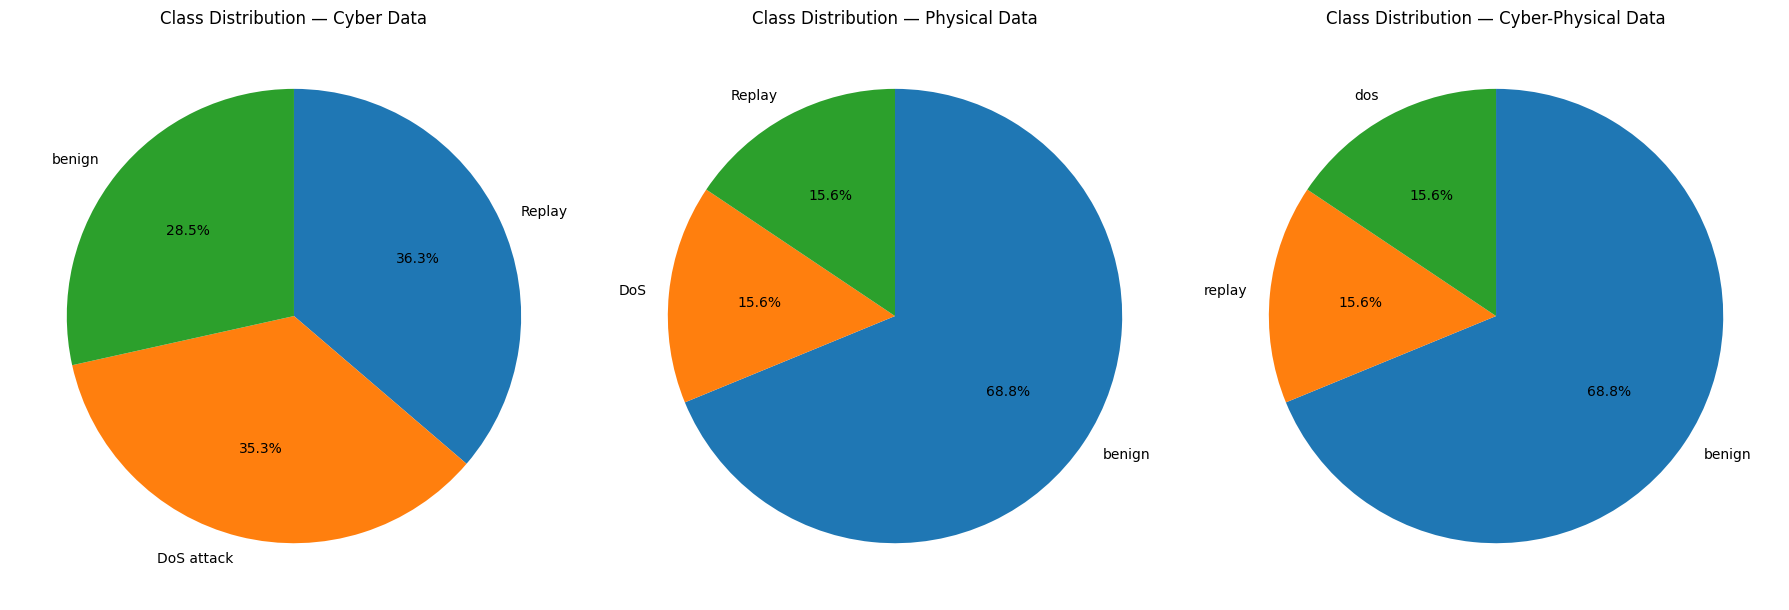

In [45]:
# === IMPORTS ===
import matplotlib.pyplot as plt
import pandas as pd

# === LOAD DATASETS ===
data_Cyber = pd.read_csv("Data/Merged_Cyber.csv")
data_Physical = pd.read_csv("Data/Merged_Physical.csv")
data_CP = pd.read_csv("Data/Merged_CP.csv")

# === COLUMN VERIFICATION ===
for name, df in [("Cyber", data_Cyber), ("Physical", data_Physical), ("Cyber-Physical", data_CP)]:
    if "class" not in df.columns:
        raise KeyError(f"❌ The 'class' column is missing in {name}")

# === CLASS COUNTS ===
class_counts_cyber = data_Cyber["class"].value_counts()
class_counts_physical = data_Physical["class"].value_counts()
class_counts_cp = data_CP["class"].value_counts()

# === CREATE SUBPLOTS (1 row, 3 columns) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Pie chart: Cyber ---
axes[0].pie(
    class_counts_cyber,
    labels=class_counts_cyber.index,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[0].set_title("Class Distribution — Cyber Data")

# --- Pie chart: Physical ---
axes[1].pie(
    class_counts_physical,
    labels=class_counts_physical.index,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[1].set_title("Class Distribution — Physical Data")

# --- Pie chart: Cyber-Physical ---
axes[2].pie(
    class_counts_cp,
    labels=class_counts_cp.index,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[2].set_title("Class Distribution — Cyber-Physical Data")

# === ADJUSTMENTS ===
plt.tight_layout()
plt.show()


### PCA

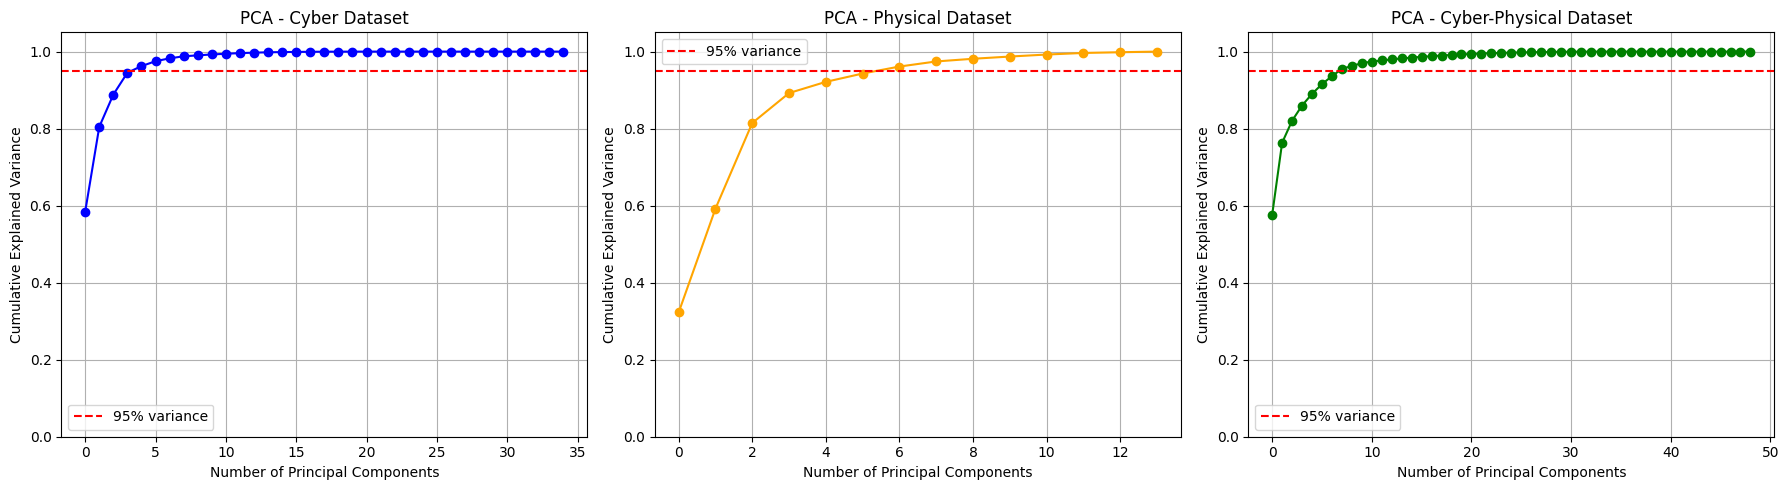

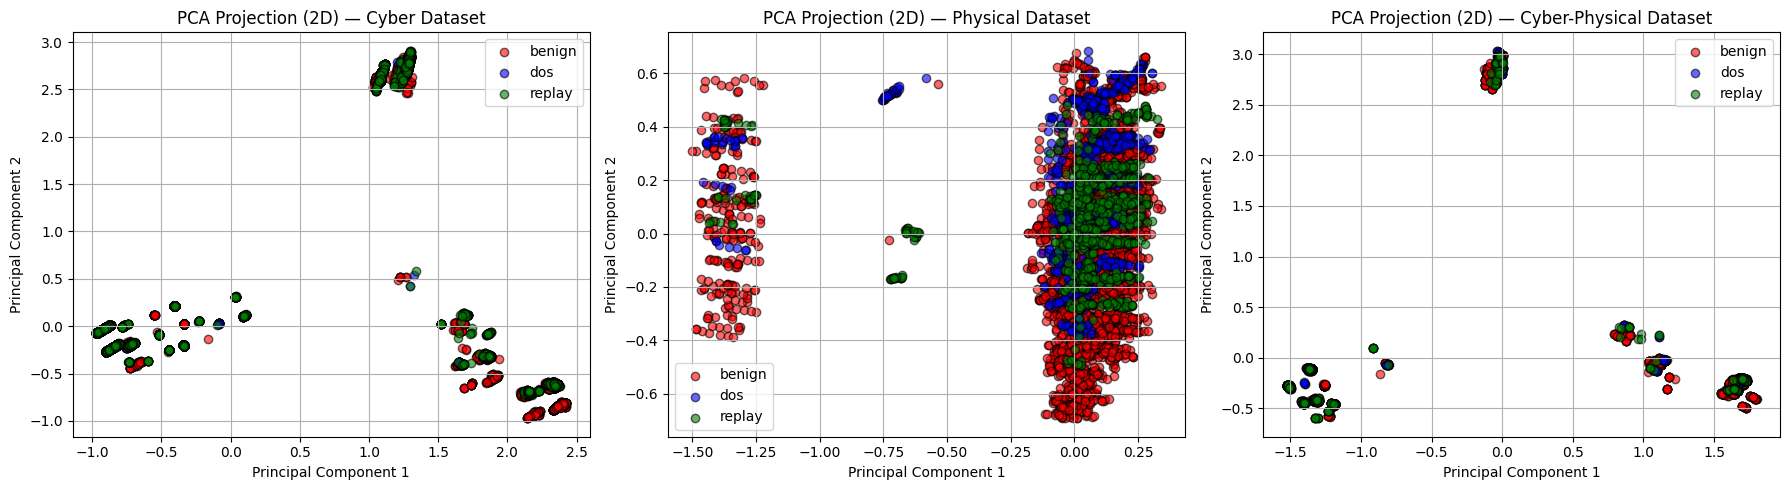

In [46]:
# === 1️⃣ PCA FIT ===
pca_cyber = PCA().fit(X_cyber_scaled)
pca_physical = PCA().fit(X_physical_scaled)
pca_cp = PCA().fit(X_cp_scaled)

# === 2️⃣ Cumulative Explained Variance ===
var_cum_cyber = np.cumsum(pca_cyber.explained_variance_ratio_)
var_cum_physical = np.cumsum(pca_physical.explained_variance_ratio_)
var_cum_cp = np.cumsum(pca_cp.explained_variance_ratio_)

# === 3️⃣ Plot cumulative variance (3 side-by-side graphs) ===
plt.figure(figsize=(18, 5))

# ---- Plot 1: Cyber Dataset ----
plt.subplot(1, 3, 1)
plt.plot(var_cum_cyber, marker='o', color='blue')
plt.title("PCA - Cyber Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

# ---- Plot 2: Physical Dataset ----
plt.subplot(1, 3, 2)
plt.plot(var_cum_physical, marker='o', color='orange')
plt.title("PCA - Physical Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

# ---- Plot 3: Cyber-Physical Dataset ----
plt.subplot(1, 3, 3)
plt.plot(var_cum_cp, marker='o', color='green')
plt.title("PCA - Cyber-Physical Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

plt.tight_layout()
plt.show()

# === 4️⃣ PCA with 2 components ===
pca2_cyber = PCA(n_components=2)
X_cyber_pca2 = pca2_cyber.fit_transform(X_cyber_scaled)

pca2_physical = PCA(n_components=2)
X_physical_pca2 = pca2_physical.fit_transform(X_physical_scaled)

pca2_cp = PCA(n_components=2)
X_cp_pca2 = pca2_cp.fit_transform(X_cp_scaled)

# === 5️⃣ Define classes and colors ===
colors = ['r', 'b', 'g', 'purple', 'orange']

classes_cyber = np.unique(y_cyber)
classes_physical = np.unique(y_physical)
classes_cp = np.unique(y_cp)

# === 6️⃣ 2D PCA Visualization (3 side-by-side graphs) ===
plt.figure(figsize=(18, 5))

# ---- PCA Cyber ----
plt.subplot(1, 3, 1)
for i, cls in enumerate(classes_cyber):
    plt.scatter(
        X_cyber_pca2[y_cyber == cls, 0],
        X_cyber_pca2[y_cyber == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Cyber Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

# ---- PCA Physical ----
plt.subplot(1, 3, 2)
for i, cls in enumerate(classes_physical):
    plt.scatter(
        X_physical_pca2[y_physical == cls, 0],
        X_physical_pca2[y_physical == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Physical Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

# ---- PCA Cyber-Physical ----
plt.subplot(1, 3, 3)
for i, cls in enumerate(classes_cp):
    plt.scatter(
        X_cp_pca2[y_cp == cls, 0],
        X_cp_pca2[y_cp == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Cyber-Physical Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



### SVM, Kernel Trick and GridSearch



==================== 🧩 DATASET: CYBER ====================
📉 Cyber sub-sampling: keeping 8275 rows
🔹 Cyber: variance explained by 4 components = 0.947

=== ⚙️ GridSearch for kernel = 'linear' ===


✅ Best parameters: {'C': 1}
🏁 Cross-validation score: 0.6242
🎯 Test accuracy: 0.6245

=== ⚙️ GridSearch for kernel = 'poly' ===
✅ Best parameters: {'C': 1, 'degree': 5}
🏁 Cross-validation score: 0.6315
🎯 Test accuracy: 0.6419

=== ⚙️ GridSearch for kernel = 'rbf' ===
✅ Best parameters: {'C': 10, 'gamma': 10}
🏁 Cross-validation score: 0.6569
🎯 Test accuracy: 0.6622

=== ⚙️ GridSearch for kernel = 'sigmoid' ===
✅ Best parameters: {'C': 0.1, 'coef0': 0, 'gamma': 'auto'}
🏁 Cross-validation score: 0.6017
🎯 Test accuracy: 0.6095


==================== 🧩 DATASET: PHYSICAL ====================
🔹 Physical: variance explained by 5 components = 0.921

=== ⚙️ GridSearch for kernel = 'linear' ===
✅ Best parameters: {'C': 0.1}
🏁 Cross-validation score: 0.6878
🎯 Test accuracy: 0.6883

=== ⚙️ GridSearch for kernel = 'poly' ===
✅ Best parameters: {'C': 1, 'degree': 5}
🏁 Cross-validation score: 0.7111
🎯 Test accuracy: 0.7126

=== ⚙️ GridSearch for kernel = 'rbf' ===
✅ Best parameters: {'C': 10, 'gamma':

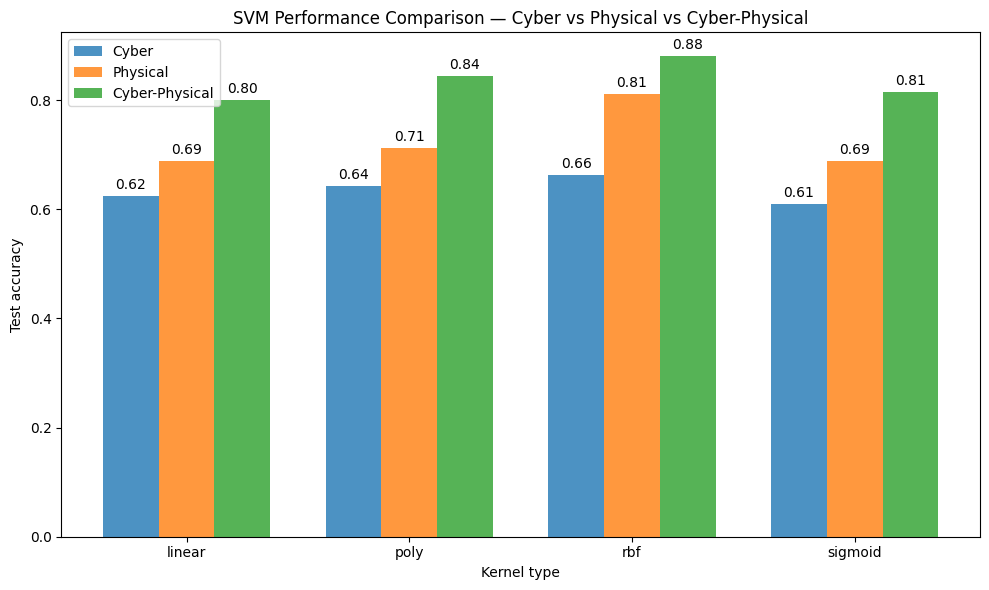

In [47]:
# === IMPORTS ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# === Parameter grids for each kernel ===
param_grids = {
    "linear": {
        "C": [0.1, 1, 10]
    },
    "poly": {
        "C": [0.1, 1],
        "degree": [2, 3, 4, 5],
    },
    "rbf": {
        "C": [0.1, 1, 10],
        "gamma": [1e-2, 1e-1, 1, 10]
    },
    "sigmoid": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "coef0": [0, 1]
    }
}

# === Store results ===
results = {"cyber": {}, "physical": {}, "cyber_physical": {}}

# === Loop through all three datasets ===
for dataset in ["cyber", "physical", "cyber_physical"]:

    print(f"\n\n==================== 🧩 DATASET: {dataset.upper()} ====================")

    # --- Dataset configuration ---
    if dataset == "cyber":
        n_half = len(X_cyber_scaled) // 4
        X_scaled = X_cyber_scaled[:n_half]
        y = y_cyber[:n_half]
        n_comp = 4
        print(f"📉 Cyber sub-sampling: keeping {n_half} rows")
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        n_comp = 5
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        n_comp = 8

    # --- PCA dimensionality reduction ---
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)
    print(f"🔹 {dataset.capitalize()}: variance explained by {n_comp} components = {np.sum(pca.explained_variance_ratio_):.3f}")

    # --- Train/test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- Loop over kernel types ---
    for kernel_choice, param_grid in param_grids.items():
        print(f"\n=== ⚙️ GridSearch for kernel = '{kernel_choice}' ===")

        grid = GridSearchCV(
            SVC(kernel=kernel_choice, decision_function_shape='ovr'),
            param_grid=param_grid,
            scoring='accuracy',
            cv=3,
            n_jobs=-1,
            verbose=0,
            refit=True
        )

        grid.fit(X_train, y_train)
        best_score = grid.best_score_
        best_params = grid.best_params_

        print(f"✅ Best parameters: {best_params}")
        print(f"🏁 Cross-validation score: {best_score:.4f}")

        # --- Final training ---
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc_test = accuracy_score(y_test, y_pred)

        print(f"🎯 Test accuracy: {acc_test:.4f}")
        results[dataset][kernel_choice] = acc_test

# === Summary of results ===
print("\n==================== 🏁 SUMMARY OF TEST ACCURACIES ====================")
for ds, scores in results.items():
    print(f"\n📊 {ds.upper()}:")
    for k, s in scores.items():
        print(f"  {k:10s} : {s:.4f}")

# === Visualization ===
fig, ax = plt.subplots(figsize=(10, 6))

kernels = list(param_grids.keys())
x = np.arange(len(kernels))
width = 0.25

cyber_scores = [results["cyber"].get(k, 0) for k in kernels]
phys_scores = [results["physical"].get(k, 0) for k in kernels]
cp_scores = [results["cyber_physical"].get(k, 0) for k in kernels]

bars1 = ax.bar(x - width, cyber_scores, width, label='Cyber', alpha=0.8)
bars2 = ax.bar(x, phys_scores, width, label='Physical', alpha=0.8)
bars3 = ax.bar(x + width, cp_scores, width, label='Cyber-Physical', alpha=0.8)

ax.set_xlabel("Kernel type")
ax.set_ylabel("Test accuracy")
ax.set_title("SVM Performance Comparison — Cyber vs Physical vs Cyber-Physical")
ax.set_xticks(x)
ax.set_xticklabels(kernels)
ax.legend()
ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)
ax.bar_label(bars3, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()




### Random Forest 

In [52]:
# === IMPORTS ===
import pandas as pd

# === LOAD MERGED DATASETS ===
data_Physical = pd.read_csv("Data/Merged_Physical.csv")
data_Cyber = pd.read_csv("Data/Merged_Cyber.csv")
data_CP = pd.read_csv("Data/Merged_CP.csv")

print("✅ Datasets successfully loaded!")
print(f"Physical: {data_Physical.shape}")
print(f"Cyber: {data_Cyber.shape}")
print(f"Cyber-Physical: {data_CP.shape}")

# === FUNCTION TO NORMALIZE CLASS LABELS ===
def normalize_class_labels(y):
    """
    Normalize all class names across datasets:
    - lowercase
    - remove spaces
    - unify variants like 'DoS attack', 'Replay Attack', etc.
    """
    y = y.astype(str).str.lower().replace(r"\s+", "", regex=True)
    return y.replace({
        "dosattack": "dos",
        "dos_attack": "dos",
        "dos": "dos",
        "dos.": "dos",
        "attackdos": "dos",
        "replay": "replay",
        "replayattack": "replay",
        "replay_attack": "replay",
        "attackreplay": "replay",
        "benign": "benign"
    })

# === DEFINE X (features) AND y (labels) ===
X_physical = data_Physical.drop(columns=['class', 'timestamp_p', 'barometer'], errors='ignore')
y_physical = normalize_class_labels(data_Physical['class'])

X_cyber = data_Cyber.drop(columns=['class', 'timestamp_c', 'frame.number'], errors='ignore')
y_cyber = normalize_class_labels(data_Cyber['class'])

X_cp = data_CP.drop(columns=['class', 'timestamp', 'frame.number', 'barometer'], errors='ignore')
y_cp = normalize_class_labels(data_CP['class'])

print("\n✅ Feature matrices (X) and normalized labels (y) defined successfully.")
print(f"Physical: X={X_physical.shape}, y={y_physical.shape}")
print(f"Cyber:    X={X_cyber.shape}, y={y_cyber.shape}")
print(f"Cyber-Physical: X={X_cp.shape}, y={y_cp.shape}")

# === VERIFY NORMALIZED CLASS DISTRIBUTIONS ===
print("\n=== 📊 Normalized Class Distributions ===")
print("Physical:", y_physical.value_counts().to_dict())
print("Cyber:", y_cyber.value_counts().to_dict())
print("Cyber-Physical:", y_cp.value_counts().to_dict())


✅ Datasets successfully loaded!
Physical: (6236, 17)
Cyber: (33102, 38)
Cyber-Physical: (6236, 53)

✅ Feature matrices (X) and normalized labels (y) defined successfully.
Physical: X=(6236, 14), y=(6236,)
Cyber:    X=(33102, 35), y=(33102,)
Cyber-Physical: X=(6236, 49), y=(6236,)

=== 📊 Normalized Class Distributions ===
Physical: {'benign': 4290, 'dos': 973, 'replay': 973}
Cyber: {'replay': 12006, 'dos': 11671, 'benign': 9425}
Cyber-Physical: {'benign': 4290, 'replay': 973, 'dos': 973}



🔹 Training Random Forest on Cyber dataset...
✅ 5-Fold Accuracy — mean: 0.7173, std: 0.0023

🔹 Training Random Forest on Physical dataset...
✅ 5-Fold Accuracy — mean: 0.9673, std: 0.0062

🔹 Training Random Forest on Cyber-Physical dataset...
✅ 5-Fold Accuracy — mean: 0.9689, std: 0.0036

✅ Per-class metrics summary:
          Dataset   Class  Accuracy  Recall     F1
0           Cyber  benign     0.850   0.890  0.870
1           Cyber     dos     0.661   0.677  0.669
2           Cyber  replay     0.668   0.626  0.646
3        Physical  benign     0.962   0.993  0.977
4        Physical     dos     0.970   0.947  0.958
5        Physical  replay     0.972   0.860  0.913
6  Cyber-Physical  benign     0.961   0.999  0.979
7  Cyber-Physical     dos     0.983   0.942  0.962
8  Cyber-Physical  replay     0.990   0.856  0.918


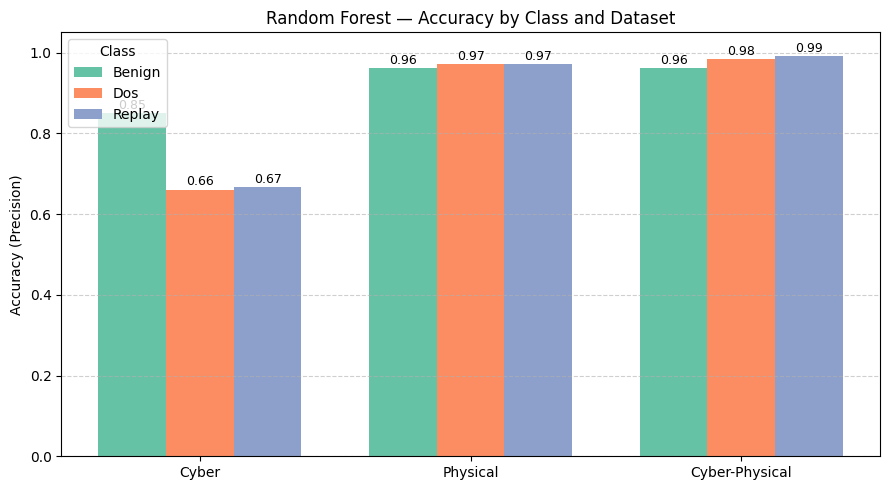

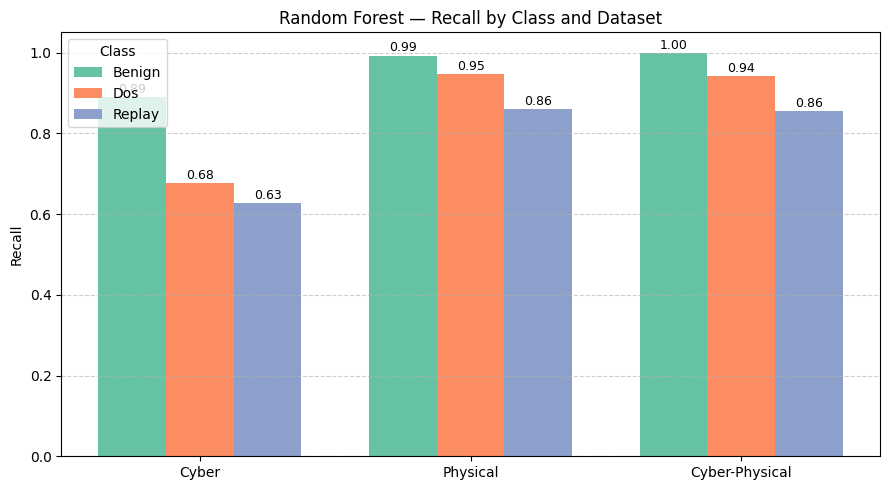

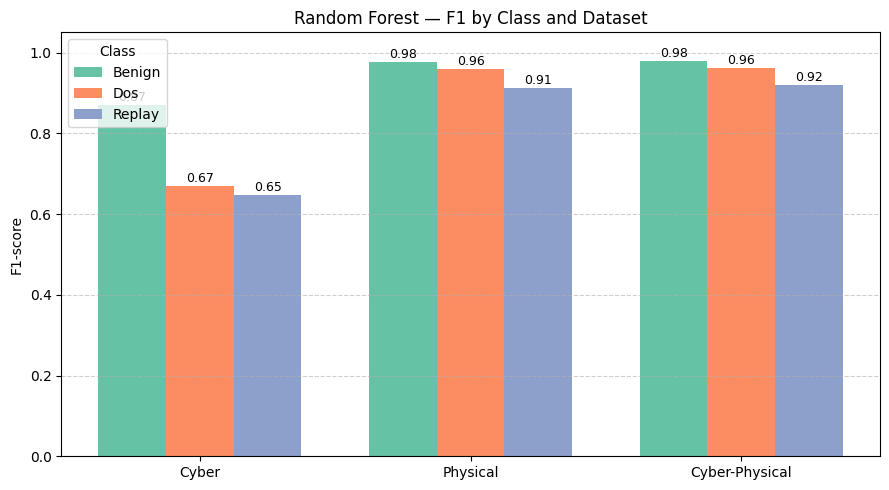



=== 🏁 K-Fold Cross-Validation Summary ===
Cyber           → Mean: 0.7173, Std: 0.0023
Physical        → Mean: 0.9673, Std: 0.0062
Cyber-Physical  → Mean: 0.9689, Std: 0.0036


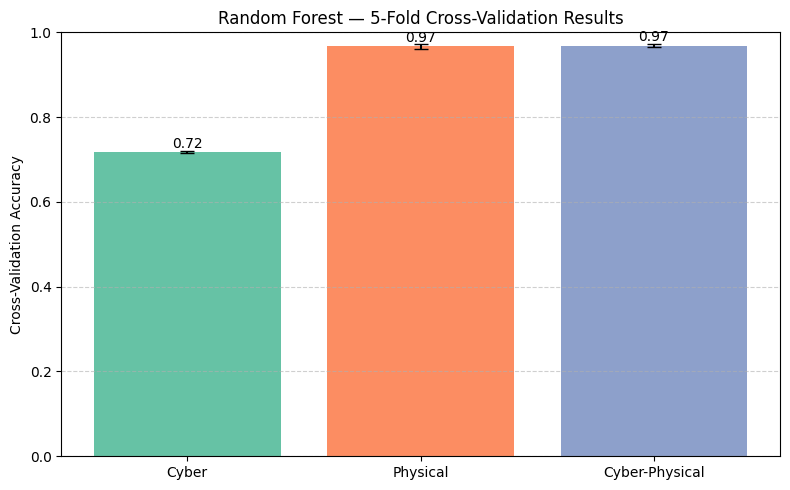

In [54]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# === CONFIGURATION ===
datasets = {
    "Cyber": (X_cyber, y_cyber),
    "Physical": (X_physical, y_physical),
    "Cyber-Physical": (X_cp, y_cp)
}

n_estimators = 200
random_state = 42
k_folds = 5

# === STORE RESULTS ===
per_class_metrics = []
kfold_results = {}

# === LOOP OVER DATASETS ===
for name, (X, y) in datasets.items():
    print(f"\n🔹 Training Random Forest on {name} dataset...")

    # Shuffle + scale
    X, y = shuffle(X, y, random_state=random_state)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=random_state, stratify=y
    )

    # Train model
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # === Compute metrics per class ===
    report = classification_report(y_test, y_pred, output_dict=True)

    for cls in report.keys():
        if cls in ["accuracy", "macro avg", "weighted avg"]:
            continue
        per_class_metrics.append({
            "Dataset": name,
            "Class": cls.lower(),
            "Accuracy": report[cls]["precision"],  # Precision used as class-wise accuracy
            "Recall": report[cls]["recall"],
            "F1": report[cls]["f1-score"]
        })

    # === Perform K-Fold Cross Validation ===
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    scores = cross_val_score(rf, X_scaled, y, cv=kf, scoring='accuracy', n_jobs=-1)
    kfold_results[name] = scores

    print(f"✅ {k_folds}-Fold Accuracy — mean: {np.mean(scores):.4f}, std: {np.std(scores):.4f}")

# === Convert metrics to DataFrame ===
df_class_metrics = pd.DataFrame(per_class_metrics)
print("\n✅ Per-class metrics summary:")
print(df_class_metrics.round(3))

# === COLORS BY CLASS ===
class_colors = {
    "benign": "#66c2a5",
    "dos": "#fc8d62",
    "replay": "#8da0cb"
}

# === Utility to make grouped bar plots ===
def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(9, 5))
    bar_width = 0.25
    datasets_order = ["Cyber", "Physical", "Cyber-Physical"]
    x = np.arange(len(datasets_order))
    class_list = list(class_colors.keys())

    for i, cls in enumerate(class_list):
        subset = df_class_metrics[df_class_metrics["Class"].str.lower() == cls]
        subset = subset.set_index("Dataset").reindex(datasets_order)
        plt.bar(
            x + i * bar_width,
            subset[metric_name],
            width=bar_width,
            label=cls.capitalize(),
            color=class_colors[cls]
        )
        # Add values on top of bars
        for j, val in enumerate(subset[metric_name]):
            if not np.isnan(val):
                plt.text(x[j] + i * bar_width, val + 0.01, f"{val:.2f}", ha='center', fontsize=9)

    plt.xticks(x + bar_width, datasets_order)
    plt.ylim(0, 1.05)
    plt.ylabel(ylabel)
    plt.title(f"Random Forest — {metric_name} by Class and Dataset")
    plt.legend(title="Class")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# === PLOTS FOR PER-CLASS METRICS ===
plot_metric("Accuracy", "Accuracy (Precision)")
plot_metric("Recall", "Recall")
plot_metric("F1", "F1-score")

# === K-FOLD CV SUMMARY & PLOT ===
print("\n\n=== 🏁 K-Fold Cross-Validation Summary ===")
for name, scores in kfold_results.items():
    print(f"{name:15s} → Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# === Plot K-Fold Results ===
plt.figure(figsize=(8, 5))
datasets_order = list(kfold_results.keys())
means = [np.mean(kfold_results[k]) for k in datasets_order]
stds = [np.std(kfold_results[k]) for k in datasets_order]

bars = plt.bar(datasets_order, means, yerr=stds, capsize=5, color=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.ylabel("Cross-Validation Accuracy")
plt.title(f"Random Forest — {k_folds}-Fold Cross-Validation Results")
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Anomaly detection: Outlier Detection vs Novelty Detection


=== CYBER DATASET (contamination=0.5) ===
Training on 9425 benign samples

🔹 Isolation Forest

🔹 Local Outlier Factor

=== PHYSICAL DATASET (contamination=0.32) ===
Training on 4290 benign samples

🔹 Isolation Forest

🔹 Local Outlier Factor

=== CYBER-PHYSICAL DATASET (contamination=0.32) ===
Training on 4290 benign samples

🔹 Isolation Forest

🔹 Local Outlier Factor

✅ Combined Results (real, unscaled data):
          Data Algo    Type    F1  Prec   Rec
         Cyber   IF Outlier 0.457 0.556 0.389
         Cyber   IF Novelty 0.859 0.819 0.903
         Cyber  LOF Outlier 0.527 0.640 0.448
         Cyber  LOF Novelty 0.865 0.830 0.904
      Physical   IF Outlier 0.314 0.310 0.318
      Physical   IF Novelty 0.347 0.337 0.358
      Physical  LOF Outlier 0.325 0.321 0.329
      Physical  LOF Novelty 0.498 0.457 0.548
Cyber-Physical   IF Outlier 0.363 0.358 0.367
Cyber-Physical   IF Novelty 0.593 0.505 0.719
Cyber-Physical  LOF Outlier 0.379 0.374 0.384
Cyber-Physical  LOF Novelty 0.615 

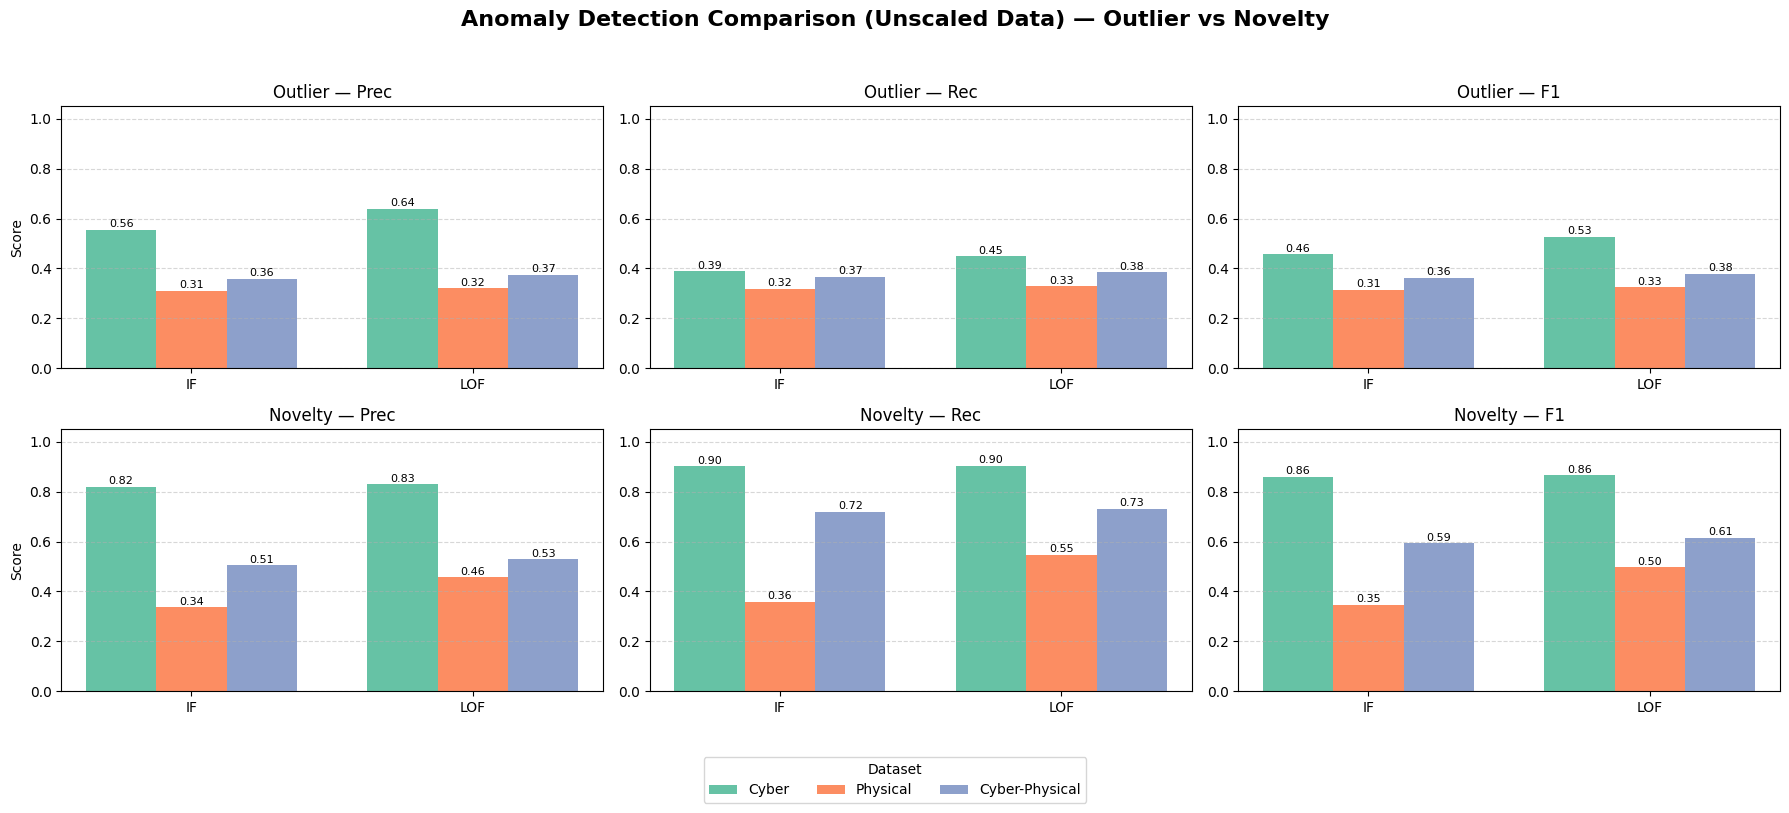

In [68]:
# ================================
#         IMPORTS
# ================================
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import warnings
# ================================
#        COMMON FUNCTION
# ================================
import warnings
from sklearn.neighbors import LocalOutlierFactor

def evaluate_model(model, X_train, X_test, y_true, mode, name, contamination):
    """Fit/predict + compute F1, precision, recall and AUC for outlier or novelty mode."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)

        if "Local Outlier Factor" in name:
            # Just increase neighbors, don't remove duplicates
            n_neighbors = min(25, len(X_train) - 1)

            if mode == "outlier":
                lof = LocalOutlierFactor(
                    n_neighbors=n_neighbors,
                    contamination=contamination,
                    novelty=False
                )
                y_pred = lof.fit_predict(X_test)
            else:
                lof = LocalOutlierFactor(
                    n_neighbors=n_neighbors,
                    contamination=contamination,
                    novelty=True
                )
                lof.fit(X_train)
                y_pred = lof.predict(X_test)
        else:
            if mode == "outlier":
                model.fit(X_test)
                y_pred = model.predict(X_test)
            else:
                model.fit(X_train)
                y_pred = model.predict(X_test)

    # === Keep consistent lengths ===
    if len(y_true) != len(y_pred):
        raise ValueError(f"Length mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}")

    y_pred = np.where(y_pred == -1, -1, 1)
    report = classification_report(
        y_true,
        y_pred,
        target_names=['Attack (-1)', 'Benign (+1)'],
        output_dict=True
    )

    f1 = report['Attack (-1)']['f1-score']
    precision = report['Attack (-1)']['precision']
    recall = report['Attack (-1)']['recall']
    auc = roc_auc_score((y_true == 1).astype(int), (y_pred == 1).astype(int))

    return f1, precision, recall, auc


def run_experiment(X, y, dataset_name, contamination):
    """Run anomaly detection on unscaled data."""
    print(f"\n=== {dataset_name.upper()} DATASET (contamination={contamination}) ===")

    mask_benign = (y == 'benign')
    X_train = X[mask_benign]
    X_test = X
    y_true = np.where(y == 'benign', 1, -1)

    print(f"Training on {len(X_train)} benign samples")

    base_models = {
        "Isolation Forest": IsolationForest(contamination=contamination, random_state=42),
    }

    results = []

    for name, base_model in base_models.items():
        print(f"\n🔹 {name}")
        model_outlier = copy.deepcopy(base_model)
        model_novelty = copy.deepcopy(base_model)

        f1_outlier, prec_outlier, rec_outlier, _ = evaluate_model(model_outlier, X_train, X_test, y_true, 'outlier', name, contamination)
        f1_novelty, prec_novelty, rec_novelty, _ = evaluate_model(model_novelty, X_train, X_test, y_true, 'novelty', name, contamination)

        results.append({
            "Dataset": dataset_name,
            "Model": name,
            "Mode": "Outlier Detection",
            "F1-score": f1_outlier,
            "Precision": prec_outlier,
            "Recall": rec_outlier
        })
        results.append({
            "Dataset": dataset_name,
            "Model": name,
            "Mode": "Novelty Detection",
            "F1-score": f1_novelty,
            "Precision": prec_novelty,
            "Recall": rec_novelty
        })

    # === Add Local Outlier Factor explicitly ===
    print("\n🔹 Local Outlier Factor")
    for mode in ['outlier', 'novelty']:
        f1, prec, rec, _ = evaluate_model(None, X_train, X_test, y_true, mode, "Local Outlier Factor", contamination)
        results.append({
            "Dataset": dataset_name,
            "Model": "Local Outlier Factor",
            "Mode": "Outlier Detection" if mode == "outlier" else "Novelty Detection",
            "F1-score": f1,
            "Precision": prec,
            "Recall": rec
        })

    return pd.DataFrame(results)

# ================================
#       RUN ALL 3 DATASETS
# ================================
df_cyber = run_experiment(X_cyber, y_cyber, "Cyber", contamination=0.5)
df_physical = run_experiment(X_physical, y_physical, "Physical", contamination=0.32)
df_cp = run_experiment(X_cp, y_cp, "Cyber-Physical", contamination=0.32)

df_all = pd.concat([df_cyber, df_physical, df_cp], ignore_index=True)

# === Clean labels ===
df_all.rename(columns={
    "Dataset": "Data",
    "Model": "Algo",
    "Mode": "Type",
    "F1-score": "F1",
    "Precision": "Prec",
    "Recall": "Rec"
}, inplace=True)

df_all["Algo"] = df_all["Algo"].replace({
    "Isolation Forest": "IF",
    "Local Outlier Factor": "LOF"
})
df_all["Type"] = df_all["Type"].replace({
    "Outlier Detection": "Outlier",
    "Novelty Detection": "Novelty"
})

df_all = df_all[["Data", "Algo", "Type", "F1", "Prec", "Rec"]].round(3)
print("\n✅ Combined Results (real, unscaled data):")
print(df_all.to_string(index=False))

# ================================
#   2×3 COMPARATIVE VISUALIZATION
# ================================
metrics = [ "Prec", "Rec","F1"]
types = ["Outlier", "Novelty"]
datasets = ["Cyber", "Physical", "Cyber-Physical"]
algos = df_all["Algo"].unique()
colors = {"Cyber": "#66c2a5", "Physical": "#fc8d62", "Cyber-Physical": "#8da0cb"}
width = 0.25
x = np.arange(len(algos))

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Anomaly Detection Comparison (Unscaled Data) — Outlier vs Novelty", fontsize=16, weight="bold")

for i, det_type in enumerate(types):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        for k, dataset in enumerate(datasets):
            subset = df_all[
                (df_all["Type"] == det_type) &
                (df_all["Data"] == dataset)
            ]
            subset = subset.set_index("Algo").reindex(algos)
            ax.bar(
                x + k * width,
                subset[metric],
                width=width,
                label=dataset if j == 0 else "",
                color=colors[dataset]
            )
            # Add value labels
            for m, val in enumerate(subset[metric]):
                if not np.isnan(val):
                    ax.text(x[m] + k * width, val + 0.01, f"{val:.2f}", ha='center', fontsize=8)

        ax.set_title(f"{det_type} — {metric}", fontsize=12)
        ax.set_xticks(x + width)
        ax.set_xticklabels(algos)
        ax.set_ylim(0, 1.05)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        if j == 0:
            ax.set_ylabel("Score")

# Shared legend (visible and centered below plots)
# === Shared legend (collect from all axes) ===
handles, labels = [], []
for ax in axes.ravel():
    h, l = ax.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in labels:  # avoid duplicates
            handles.append(hh)
            labels.append(ll)

fig.legend(
    handles,
    labels,
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.02),
    fontsize=10,
    title="Dataset"
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


